# **Representational similarity analysis: a tutorial with PcmPy**
written for [Diedrichsen Lab](https://www.diedrichsenlab.org) and [Brain and Mind Institute](https://www.uwo.ca/bmi/)

This tutorial will walk you through the basic concept to understand representational similarity analysis (RSA) and how to apply it using the PcmPy toolbox. [Click here](https://pcm-toolbox-python.readthedocs.io/en/latest/) for more documentation about the PcmPy. To find out how to use the rsatoolbox instead, you can check [this tutorial](https://github.com/mnlmrc/didactic/blob/main/rsa_rsatoolbox.ipynb).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PcmPy as pcm
import pickle
import scipy
plt.style.use('default')


Example dataset
--
Throughout the tutorial, we use example fMRI data from an experiment in which participants responded to tactile stimuli on either the index or ring finger, following a visual cue that indicated the probability of stimulation for each finger. The visual cues were 0%-100% ring-index, 25%-75%, 50%-50%, 75%-25% or 100%-0%. To simplify, we will use condition labels only reporting the index probability, i.e., 0%, 25%, 50%, 75%, 100%. The data were collected in ten blocks. In the first-level GLM, we modelled neural activation $y_i$ in the $ i^{th} $ voxel as a linear combination of 5 regressors of interests, each corresponding to a probability cue:

$$ y_i = X \beta_i + \epsilon $$

The $\beta$ coefficients from each regressor indicate how much each voxel was activated for each probability cue. The goal of RSA is to understand whether voxels show different **activity patterns** between conditions, regardless of the overall amount of activation. Let's first load the data:

In [4]:
f = open('data_demo_smp.p', 'rb')
Y, ResMS, residuals, cond_vec, part_vec, cond_names = pickle.load(f)
N = Y.shape[1]

The second moment matrix
--
A central concept to keep in mind to understand RSA is the **second moment matrix** or $\mathbf{G}$:

$$ G = \frac{{YY^T}}{P} $$

Where $Y$ is a matrix with experimental observations (e.g., trials, conditions) in the rows and channels (e.g., electrodes, voxels) in the columns and $P$ is the number of channels. In our example case, each row in Y contains the beta coefficients estimated in the primary somatosensory cortex (S1) for each condition. Note that the second moment matrix is different from the variance-covariance matrix:

$$ \mathsf{\Sigma} = \frac{(Y - \bar{Y})^T (Y - \bar{Y})}{N - 1} $$

Here, we subtract the column-wise mean $\bar{Y}$ from $Y$. Instead, the second moment matrix maintains information about the mean activation observed in each condition.

Let's now compute the second moment matrix for the first run in our example data:

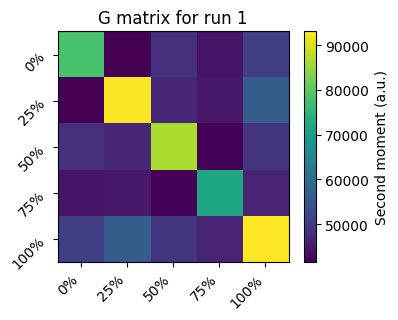

In [5]:
G = Y[:5] @ Y[:5].T / N

plt.figure(figsize=(4,3))
plt.imshow(G)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45, ha='right')
plt.title('G matrix for run 1')
plt.colorbar(label='Second moment (a.u.)')
plt.show()

Euclidean distance
--
From the second moment matrix it is possible to calculate the **squared Euclidean distances** between activity patterns observed in condition. Each pattern of activity is a P-dimensional vector, where P is the number of voxels in which activity was sampled. In the example dataset we are using in this tutorial, S1 contains 1152 voxels, so each activity pattern is 1152-dimensional vector. The squared Euclidean distance between two vectors $ \mathsf{y}_{i} $ and $ \mathsf{y}_{j} $ is:

$$ \mathsf{D}_{i,j}^2 = (y_{i} - y_{j})(y_{i} - y_{j})^T $$

Expanding the terms inside the parentheses:

$$ \mathsf{D}_{i,j}^2 = y_{i}y_{j}^T - 2y_{i}y_{j}^T + y_{i}y_{j}^T $$

If we look back at the definition of second moment matrix, for any $i$ and $j$:

$$ {G}_{i,j} = \frac{y_{i}y_{j}^T}{P} $$

Therefore, we can rewrite the squared Euclidean distance formula for the first block:

$$ {D}_{i,j}^2 = G_{i,i} - 2G_{i,j} + G_{j,j} $$

In PcmPy, we can compute the ${D}^2$ from $G$ using the `G_to_dist` function:

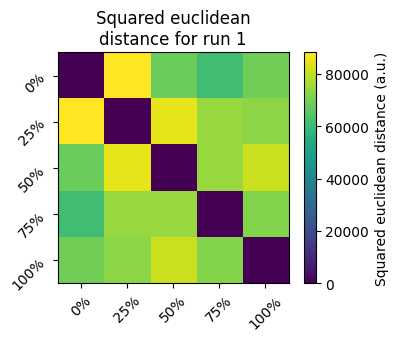

In [97]:
D_eucl = pcm.G_to_dist(G)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Squared euclidean\ndistance for run 1')
plt.colorbar(label='Squared euclidean distance (a.u.)')

Cross-validation
--
The problem with this distance metric is that it will be always (and trivially) larger than zero, even when there is no true distance between conditions. This is because data are collected in the presence of noise. Noise inflates distances: two conditions will be always show some distance relative to each other because noise pulls them apart. More specifically, using the above definition of second moment matrix $G$, in the $nth$ block $\hat{G_n}$ is estimated as:

$$ \hat{G_n} = \frac{{Y_n Y_n^T}}{N} $$

But $Y_n$ is affected noise $ \epsilon_n $. Therefore, $\hat{G_n}$ becomes:

$$ \hat{G_n} = (Y_n + \epsilon_n)(Y_n + \epsilon_n)^T $$

Expanding:

$$ \hat{G_n} = Y_n Y_n^T + Y_n\epsilon_n^T + \epsilon_n Y_n^T + \epsilon_n \epsilon_n^T $$

$ Y_n\epsilon_n^T=0 $  because noise is assumed to be orthogonal to the data. Therefore:

$$ \hat{G_n} = Y_nY_n^T + \epsilon_n \epsilon_n^T $$

$\epsilon_n \epsilon_n^T$ corresponds to the covariance of the noise $\Sigma$. Thus, the expected value of $\hat{G_n}$ estimated in the $nth$ block is:

$$\mathbb{E}[\hat{G_n}] = G_n + \Sigma $$

As a consequence, the expected estimate of distance between two conditions $y_{n,i}$ and $y_{n,j}$ in the first block becomes:

$$\mathbb{E}[\hat{D}_{n,i,j}^2] = y_{n,i} y_{n,i}^T + \epsilon_{n,i} \epsilon_{n,i}^T - 2(y_{n,i} y_{n,j}^T + \epsilon_{n,i} \epsilon_{n,j}^T) + y_{n,j} y_{n,j}^T + \epsilon_{n,j} \epsilon_{n,j}^T $$

That is, the estimate of the distance $\hat{D}_{n,i,j}^2$ is inflated by $ \epsilon_{n,i} \epsilon_{n,i}^T -2\epsilon_{n,i} \epsilon_{n,j}^T +  \epsilon_{n,j} \epsilon_{n,j}^T$

How do we obtain an unbiased $\hat{G}$ that gets rid of $\Sigma$? In RSA, this is achieved by computing the cross-validated second moment matrix $G_{cv}$:

$$ Gc = \frac{1}{N} \sum_{i=1}^{N} Y_i \bar{Y_{\neg i}}^T $$

Where $N$ is the number of blocks $Y_i$ is the data from one block and $\bar{Y_{\neg i}}$ is the average of all blocks except $i$:

$$ \bar{Y}_{\neg i} = \frac{1}{N-1} \sum_{j \neq i} Y_j $$

The cross-validated second moment matrix between two blocks $i$ and $j$ is:

$$ \hat{Gc_{i,j}} = \frac{{Y_{i}Y_{j}^T}}{P} $$

$Y_i$ and $Y_j$ will be affected by noise $\epsilon_i$ and $\epsilon_j$:

$$ \hat{Gc_{i,j}} = (Y_{i} + \epsilon_{i})(Y_{i} + \epsilon_{j})^T $$

Expanding:

$$ \hat{Gc_{i,j}} = Y_{i}Y_{j}^T + Y_{i}\epsilon_{j}^T + \epsilon_{i}Y_{j}^T + \epsilon_{i} \epsilon_{j}^T $$

In this case, not only $Y_{i} \epsilon_{j}^T=0$ and $\epsilon_{i}Y_{j}^T=0$, but also $\epsilon_{i} \epsilon_{j}^T=0 $ because the noise is assumed to be orthogonal between different blocks. This means that, with cross-validation, we achieved an unbiased estimate of the second moment matrix.

The cross-validated G matrix can be computed in PcmPy using the `est_G_crossval` function. `cond_vec` is  a vector of condition labels and `part_vec` is a vector of partition labels (i.e., the block number):


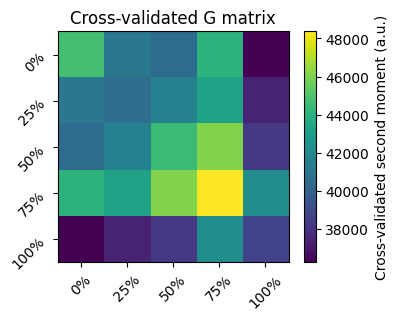

In [98]:
G_cv, _ = pcm.est_G_crossval(Y, cond_vec, part_vec)

plt.figure(figsize=(4, 3))
plt.imshow(G_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated G matrix')
plt.colorbar(label='Cross-validated second moment (a.u.)')

From `G_cv` we can now compute the cross-validated squared euclidean distance with `G_to_dist`. Importantly, cross-validated distance **CAN BE NEGATIVE**. This might seem counterintuitive, but we have to keep in mind that what we are computing is an **estimate** of the true distances. If $\mathbb{E}[\hat{D}_{n,i,j}^2] = 0 $, then $\hat{D}_{n,i,j}^2$ will fluctuate around 0 across observations, showing negative value half of the times.

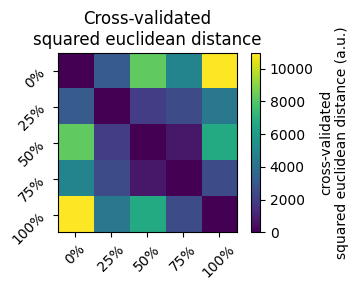

In [99]:
D_eucl_cv = pcm.G_to_dist(G_cv)

plt.figure(figsize=(4,3))
plt.imshow(D_eucl_cv)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated\nsquared euclidean distance')
plt.colorbar(label='cross-validated\nsquared euclidean distance (a.u.)')
plt.tight_layout()

Prewhitening and Mahalanobis distance
--
There is another problem that we need to address to accurately estimate distances. Different channels often have different noise variance, or correlated noise with each other. This introduces distortions in the distances between conditions. Let's look at this problem in some simulated data:

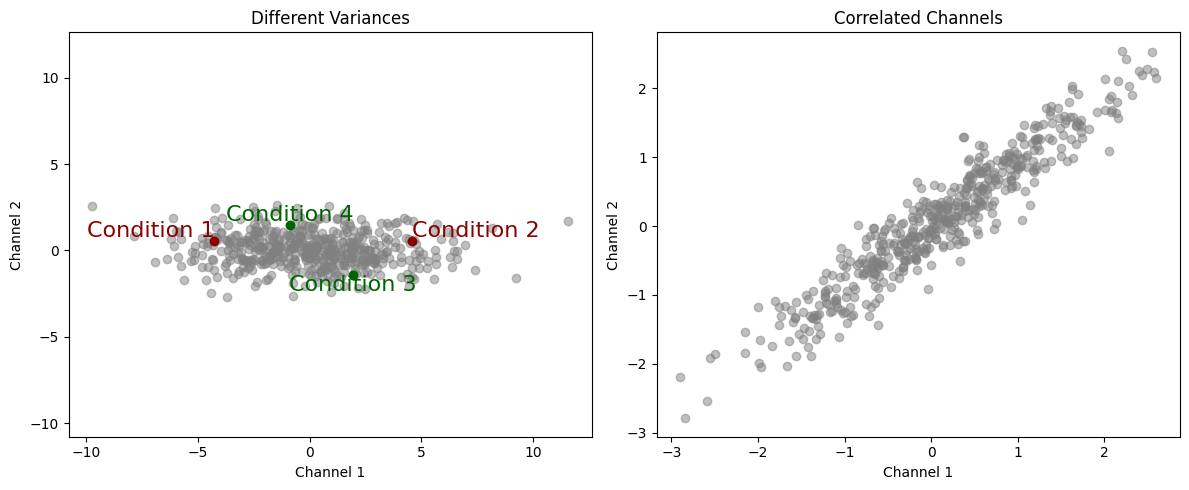

In [100]:
# Generate synthetic data with different variances and correlations
np.random.seed(42)
n_samples = 500

# Scenario 1: Different variances
x1 = np.random.randn(n_samples) * 3  # Large variance
y1 = np.random.randn(n_samples)  # Small variance

# Scenario 2: Correlated channels
x2 = np.random.randn(n_samples)
y2 = 0.9 * x2 + np.random.randn(n_samples) * 0.3  # Strong correlation

# Create a scatter plot to visualize these issues
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot: Different variances
ax[0].scatter(x1, y1, alpha=0.5, color='grey')
ax[0].set_ylim(ax[0].get_xlim())
ax[0].set_title("Different Variances")
ax[0].set_xlabel("Channel 1")
ax[0].set_ylabel("Channel 2")

ax[0].text(x1[23], y1[23], 'Condition 1', color='darkred', ha='right', va='bottom',fontsize=16)
ax[0].scatter(x1[23], y1[23], color='darkred')

ax[0].text(x1[3], y1[3], 'Condition 2', color='darkred', ha='left', va='bottom',fontsize=16)
ax[0].scatter(x1[3], y1[3], color='darkred')

ax[0].text(x1[2], y1[2], 'Condition 3', color='darkgreen', ha='center', va='top',fontsize=16)
ax[0].scatter(x1[2], y1[2], color='darkgreen')

ax[0].text(x1[43], y1[43], 'Condition 4', color='darkgreen', ha='center',va='bottom', fontsize=16)
ax[0].scatter(x1[43], y1[43], color='darkgreen')

# Plot: Correlated channels
ax[1].scatter(x2, y2, alpha=0.5, color='grey')
ax[1].set_title("Correlated Channels")
ax[1].set_xlabel("Channel 1")
ax[1].set_ylabel("Channel 2")

plt.tight_layout()
plt.show()

In the left panel, each gray point represent an activity pattern defined by Channel 1 and Channel 2 for one condition. The distance between Condition 1 and Condition 2 is larger compared to the distance between Condition 3 and Condition 4 because Channel 1 has a much larger variance compared to Channel 2. The same may happen if the two channels are highly correlated, like in the scenario depicted in the right panel. Something similar can happend in fMRI data. This is the covariance matrix of the first 100 voxels in S1:

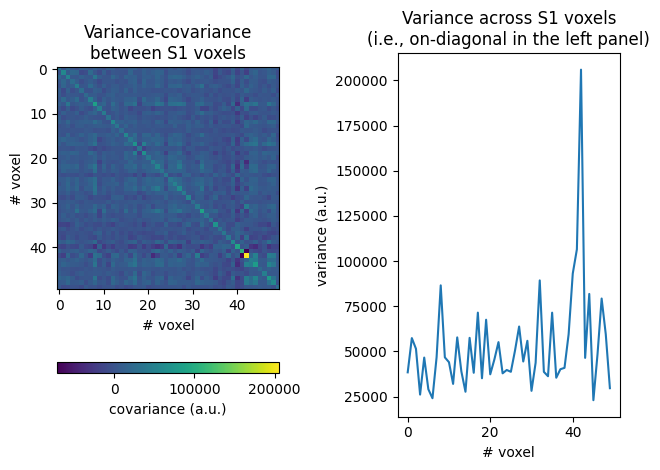

In [10]:
cov = np.cov(Y[:, :50].T)

fig, ax = plt.subplots(1, 2)

cax = ax[0].imshow(cov)
ax[0].set_xlabel('# voxel')
ax[0].set_ylabel('# voxel')
ax[0].set_title('Variance-covariance\nbetween S1 voxels')

ax[1].plot(np.diag(cov))
ax[1].set_ylabel('variance (a.u.)')
ax[1].set_xlabel('# voxel')
ax[1].set_title('Variance across S1 voxels\n(i.e., on-diagonal in the left panel)')

fig.colorbar(cax, ax=ax[0], orientation="horizontal", label="covariance (a.u.)", pad=0.2)

fig.tight_layout()
plt.show()

Both the variance (on-diagonal, see also right panel) and the covariance (off-diagonal) vary substantially across voxels. In part, this is because the beta coefficients are estimated in the presence of noise which is different across voxels and distinctively correlated between voxels. In RSA, we correct for this by prewhitening our beta coefficients:

$$ Y_{prewhitened} = \Sigma^{\frac{1}{2}}Y $$

Where $\Sigma$ is the variance-covariance matrix of the residuals from the first-level GLM. There are two types of prewhitening we can perform on beta coefficients:

- **Univariate prewhitening**: we assume that covariance between voxels is 0 and only correct for differences in noise variance (i.e., the distortion depicted in the left panel of cell 7). To do this, we divide our betas by the square root of the residual mean squares stored in the ResMS.nii file after GLM estimation with SPM12.
- **Multivariate prewhitening**: we prewhiten the data using the full covariance matrix of the noise $\Sigma$. 

We will first use univariate prewhitening:

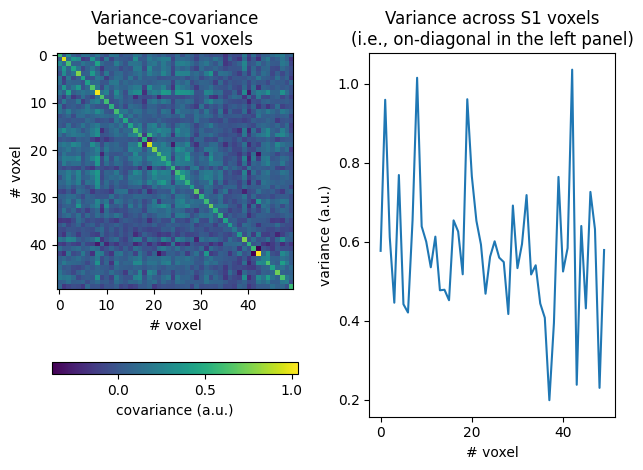

In [11]:
Y_uprewhitened = Y / np.sqrt(ResMS)

cov_prewhitened = np.cov(Y_uprewhitened[:, :50].T)

fig, ax = plt.subplots(1, 2)

cax = ax[0].imshow(cov_prewhitened)
ax[0].set_xlabel('# voxel')
ax[0].set_ylabel('# voxel')
ax[0].set_title('Variance-covariance\nbetween S1 voxels')

ax[1].plot(np.diag(cov_prewhitened))
ax[1].set_ylabel('variance (a.u.)')
ax[1].set_xlabel('# voxel')
ax[1].set_title('Variance across prewhitened S1 voxels\n(i.e., on-diagonal in the left panel)')

fig.colorbar(cax, ax=ax[0], orientation="horizontal", label="covariance (a.u.)", pad=0.2)

fig.tight_layout()
plt.show()

Univariate prewhitening made variances across voxels more homogeneous. The squared Euclidean distance between patterns $y_i$ and $y_j$ prewhitened using the covariance of the noise is:

$$ D_{i,j}^2 = (\Sigma^{\frac{1}{2}} y_i - \Sigma^{\frac{1}{2}} y_j) (\Sigma^{\frac{1}{2}} y_i - \Sigma^{\frac{1}{2}} y_j)^T $$

Expanding:

$$ D_{i,j}^2 = \Sigma^{-1} y_i y_i^T + \Sigma^{-1} y_j y_j^T - 2\Sigma^{-1} y_j y_j^T $$

We can now group for $ \Sigma^{-1} $:

$$ D_{i,j}^2 = ( y_i - y_j) \Sigma^{-1} (y_i - y_j)^T$$

This new distance metric corresponds to the Euclidean distance normalized by the covariance of the noise and is generally referred to as **Mahalanobis distance**. To obtain the **cross-validated mahalanobis distance** or **crossnobis distance** we just need to submit the prewhitened beta coefficients to `est_G_crossval` and then transform the G matrix into a squared distance matrix with `G_to_dist`:

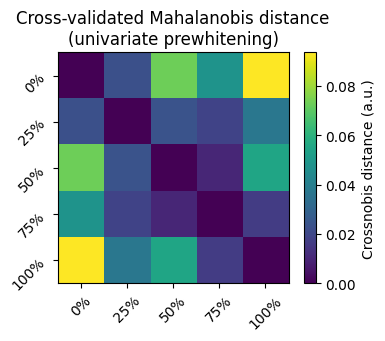

In [108]:
G_crossnobis, _ = pcm.est_G_crossval(Y_uprewhitened, cond_vec, part_vec)
D_crossnobis = pcm.G_to_dist(G_crossnobis)

plt.figure(figsize=(4, 3))
plt.imshow(D_crossnobis)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated Mahalanobis distance\n(univariate prewhitening)')
plt.colorbar(label='Crossnobis distance (a.u.)')

To perform multivariate prewhitening, we need the full timeseries of the residuals from first-level GLM, which is not output by SPM12. We can retrieve it using the `spm` module of the `nitools` toolbox:

```
SPM = spm.SpmGlm('/path/to/glm/folder')
SPM.get_info_from_spm_mat() # retrieve SPM.mat file
mask = 'path/to/roi/mask.nii' # in our case, the mask for left S1 
residuals, _, _ = SPM.get_residuals(mask) # residuals here is a timepoints by voxel matrix
```

For this example, we pre-computed the timeseries of the residuals, let's load it and compute the noise covariance $\Sigma$:

In [104]:
residuals = np.load('residuals.npy')
sigma = np.cov(residuals.T)

Now we can prewhiten the data by dividing Y by the matrix square root of $\Sigma$:

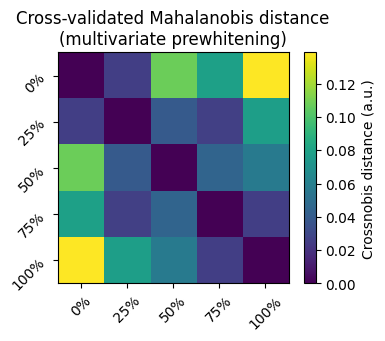

In [109]:
# remember that here you need to use scipy.linalg.sqrtm (matrix square root) and not np.sqrt (element-wise square root)
Y_mprewhitened = Y @ np.linalg.pinv(scipy.linalg.sqrtm(sigma))

G_crossnobis, _ = pcm.est_G_crossval(Y_mprewhitened, cond_vec, part_vec)
D_crossnobis = pcm.G_to_dist(G_crossnobis)

plt.figure(figsize=(4, 3))
plt.imshow(D_crossnobis)
plt.xticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.yticks(np.arange(len(cond_names)), cond_names, rotation=45)
plt.title('Cross-validated Mahalanobis distance\n(multivariate prewhitening)')
plt.colorbar(label='Crossnobis distance (a.u.)')
